In [18]:
#%matplotlib widget
import matplotlib.pyplot as plt 

import ipywidgets as widgets
import numpy as np
import os
import pickle
import sys, math
from glob import glob

import colour
from colour_hdri.plotting import plot_tonemapping_operator_image
colour.plotting.colour_style()
colour.utilities.describe_environment();

#import cv2 as cv
import skimage
import imageio

from astropy.io import fits
from colour.models import RGB_COLOURSPACES, RGB_luminance

colorspace = RGB_COLOURSPACES['sRGB']

import astrobf
from astrobf.utils import mask_utils
from astrobf.utils.mask_utils import *

from matplotlib import patches
from matplotlib.collections import PatchCollection

import statmorph
from statmorph.utils import image_diagnostics

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.8.5 (default, Sep  4 2020, 07:30:14)                       *
*                [GCC 7.3.0]                                                  *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.3.16                                                       *
*       colour-hdri : 0.1.8                                                   *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.9.0                                                       *
*       matplotlib : 3.3.2                                                    *
*       networkx : 2.5                  

In [4]:
dataset = ['EFIFI','Nair'][0]
basedir = ['../../bf_data/EFIGI_catalog/','../../bf_data/Nair_and_Abraham_2010/'][0]
fitsdir = basedir + ['fits_temp_Jan_19/','fits_temp_Dec_28/'][0]

out_dir = basedir+'out1/'

#wdir = '../../OBSdata/efigi-1.6/ima_r/'
fns_g = glob(fitsdir+"*/*g.fits")
fns_r = glob(fitsdir+"*/*r.fits")
fns_i = glob(fitsdir+"*/*i.fits")

fns_g.sort()
fns_r.sort()
fns_i.sort()

eps = 1e-6

In [5]:
def extract_gid(g_path):
    import re
    return int(re.split('(\d+)',g_path.split('/')[-2])[1])

gids = [extract_gid(fn) for fn in fns_r]

# 2. Build a mask (GMM)

In [6]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

## Can image sizes vary? probably not. 
-> I don't thnk all of thousands of features are invariant to the image size, even though only empty pixels are cut.

In [7]:
sub_rows = 3
eps = 1e-5

Where is convex hull mask gone??? inside gen_stamp??

# StatMorph

## Need Image, Mask, Weight, and PSF

In [50]:
import re

In [16]:
morphs=[]
for i, fn in enumerate(fns_r):
    if i % 500 == 499:
        pickle.dump(morphs, open(out_dir+f"Morphs/morphs{i:05d}.pickle", "wb"))
        morphs=[]
        print(i)

    img_name = fn.split("/")[-2]
    gid = int(re.split('(\d+)',img_name)[1])
    if dataset=="Nair": img_name = img_name.split('.')[0]
    hdulist = fits.open(fn)
    # Ensure pixel values are positive
    img = hdulist[0].data
    img -= (img.min() - eps) 
    
    mask = pickle.load(open(out_dir+f"/masks/{img_name}_mask.pickle", 'rb'))
    
    weight = fits.open(fn.replace(".fits", ".weight.fits"))[0].data
    subtracted = img.copy()
    subtracted[~mask] = 0

    morph = statmorph.source_morphology(
        subtracted, mask, weightmap=weight)[0]#, gain=4000)[0] ##
    hdulist.close()
    morph._gid = gid
    morphs.append(morph)
    
pickle.dump(morphs, open(out_dir+f"Morphs/morphs{i:05d}.pickle", "wb"))

/home/hoseung/Work/tonemap/statmorph/statmorph/statmorph.py:506: RuntimeWarning: invalid value encountered in sqrt
  local_std = np.sqrt(local_mean2 - local_mean**2)


3999


/home/hoseung/Work/tonemap/statmorph/statmorph/statmorph.py:506: RuntimeWarning: invalid value encountered in sqrt
  local_std = np.sqrt(local_mean2 - local_mean**2)
/home/hoseung/Work/tonemap/statmorph/statmorph/statmorph.py:506: RuntimeWarning: invalid value encountered in sqrt
  local_std = np.sqrt(local_mean2 - local_mean**2)
/home/hoseung/Work/tonemap/statmorph/statmorph/statmorph.py:506: RuntimeWarning: invalid value encountered in sqrt
  local_std = np.sqrt(local_mean2 - local_mean**2)
/home/hoseung/Work/tonemap/statmorph/statmorph/statmorph.py:506: RuntimeWarning: invalid value encountered in sqrt
  local_std = np.sqrt(local_mean2 - local_mean**2)


/home/hoseung/Work/tonemap/statmorph/statmorph/statmorph.py:506: RuntimeWarning: invalid value encountered in sqrt
  local_std = np.sqrt(local_mean2 - local_mean**2)


In [167]:
all_morphs = glob(out_dir+"Morphs/final*.pickle")
all_morphs.sort()
all_morphs

['../../bf_data/EFIGI_catalog/out1/Morphs/final_morphs1499.pickle',
 '../../bf_data/EFIGI_catalog/out1/Morphs/final_morphs1999.pickle',
 '../../bf_data/EFIGI_catalog/out1/Morphs/final_morphs2499.pickle',
 '../../bf_data/EFIGI_catalog/out1/Morphs/final_morphs2999.pickle',
 '../../bf_data/EFIGI_catalog/out1/Morphs/final_morphs3499.pickle',
 '../../bf_data/EFIGI_catalog/out1/Morphs/final_morphs3999.pickle',
 '../../bf_data/EFIGI_catalog/out1/Morphs/final_morphs4457.pickle',
 '../../bf_data/EFIGI_catalog/out1/Morphs/final_morphs499.pickle',
 '../../bf_data/EFIGI_catalog/out1/Morphs/final_morphs999.pickle']

In [170]:
#result_arr = np.zeros(ngal, dtype=[('id',int),('ttype',int)]+[(ff,float) for ff in fields])
plt.ioff()
for alm in all_morphs[3:7]:
    mps = pickle.load(open(alm,'rb'))
    #morphs=[]
    for morph in mps:
        #if i < 900: 
        #    i+=1
        #    continue
        fn = fns_r[i]
        img_name = fn.split("/")[-2]
        gid = int(re.split('(\d+)',img_name)[1])
        hdulist = fits.open(fn)
        # Ensure pixel values are positive
        img = hdulist[0].data
        img -= (img.min() - eps) 
        morph._gid = gid
        #morphs.append(morph)
        image_diagnostics.make_figure(morph, nrows=3,
                                      savefig=out_dir+f'stat_png/New{morph._gid}_summary.png',
                                      img_org=img)
                
        #i+=1
    #pickle.dump(morphs, open(out_dir+f"Morphs/morphs_id_added_{i}.pickle", "wb"))
        

KeyboardInterrupt: 

종종 fit 실패함. 이상한 object가 많으니 충분히 그럴 수 있긴 함. 눈으로 확인.

'모범적인' Sa, Sb, Sc, Sd가 잘 보이도록만 만들면 됨. fore/backgroud object 때문에 fit이 안 되는 경우는 그냥 무시. 얼마나 자주 그러는지만 체크. 




###  Collect good galaxy morphs

In [171]:
# Good galaxies after visual inspection
good_list = glob("/home/hoseung/Work/tonemap/bf_data/EFIGI_catalog/out1/stat_png/good/*.png")
good_gids=[]
for gg in good_list:
    good_gids.append(int(gg.split("/")[-1].split('New')[1].split("_")[0]))    
good_gids.sort()

# Corresponding morphs
all_morphs = glob(out_dir+"Morphs/final_morphs*.pickle")
good_morphs=[]
for alm in all_morphs:
    mps = pickle.load(open(alm,'rb'))
    for morph in mps:
        if morph._gid in good_gids:
            good_morphs.append(morph)

pickle.dump(good_morphs, open(out_dir+"Morphs/good{}.pickle".format(len(good_morphs), "wb"), 
                              protocol=pickle.HIGHEST_PROTOCOL)

### Morphology matrix

In [173]:
# Put useful measurements into a numpy array
fields = [
    'xc_centroid', 'yc_centroid', 
    'ellipticity_centroid', 'elongation_centroid', 'orientation_centroid',
    'xc_asymmetry', 'yc_asymmetry',
    'ellipticity_asymmetry', 'elongation_asymmetry', 'orientation_asymmetry',
    'rpetro_circ', 'rpetro_ellip', 'rhalf_circ', 'rhalf_ellip',
    'r20', 'r80',
    'gini', 'm20', 'gini_m20_bulge', 'gini_m20_merger',
    'sn_per_pixel', 'concentration', 'asymmetry', 'smoothness',
    'intensity', 'deviation', 'multimode',
    'sersic_xc', 'sersic_yc', 'sersic_amplitude', 'sersic_rhalf', 'sersic_n', 'sersic_ellip', 'sersic_theta',
    'sky_mean', 'sky_median', 'sky_sigma']

ngal = len(good_morphs)
result_arr = np.zeros(ngal, 
                      dtype=[('id',int),('ttype',int),('flag',bool),('flag_sersic',bool)]
                           +[(ff,float) for ff in fields])
for i, morph in enumerate(good_morphs):
    result_arr[i]['id'] = morph._gid
    for ff in fields:
        result_arr[i][ff] = getattr(morph, ff)

In [174]:
print("Number of 'bad measurements afther visual inspection =", np.sum(result_arr['flag']))

Number of 'bad measurements afther visual inspection = 0


<IPython.core.display.Javascript object>


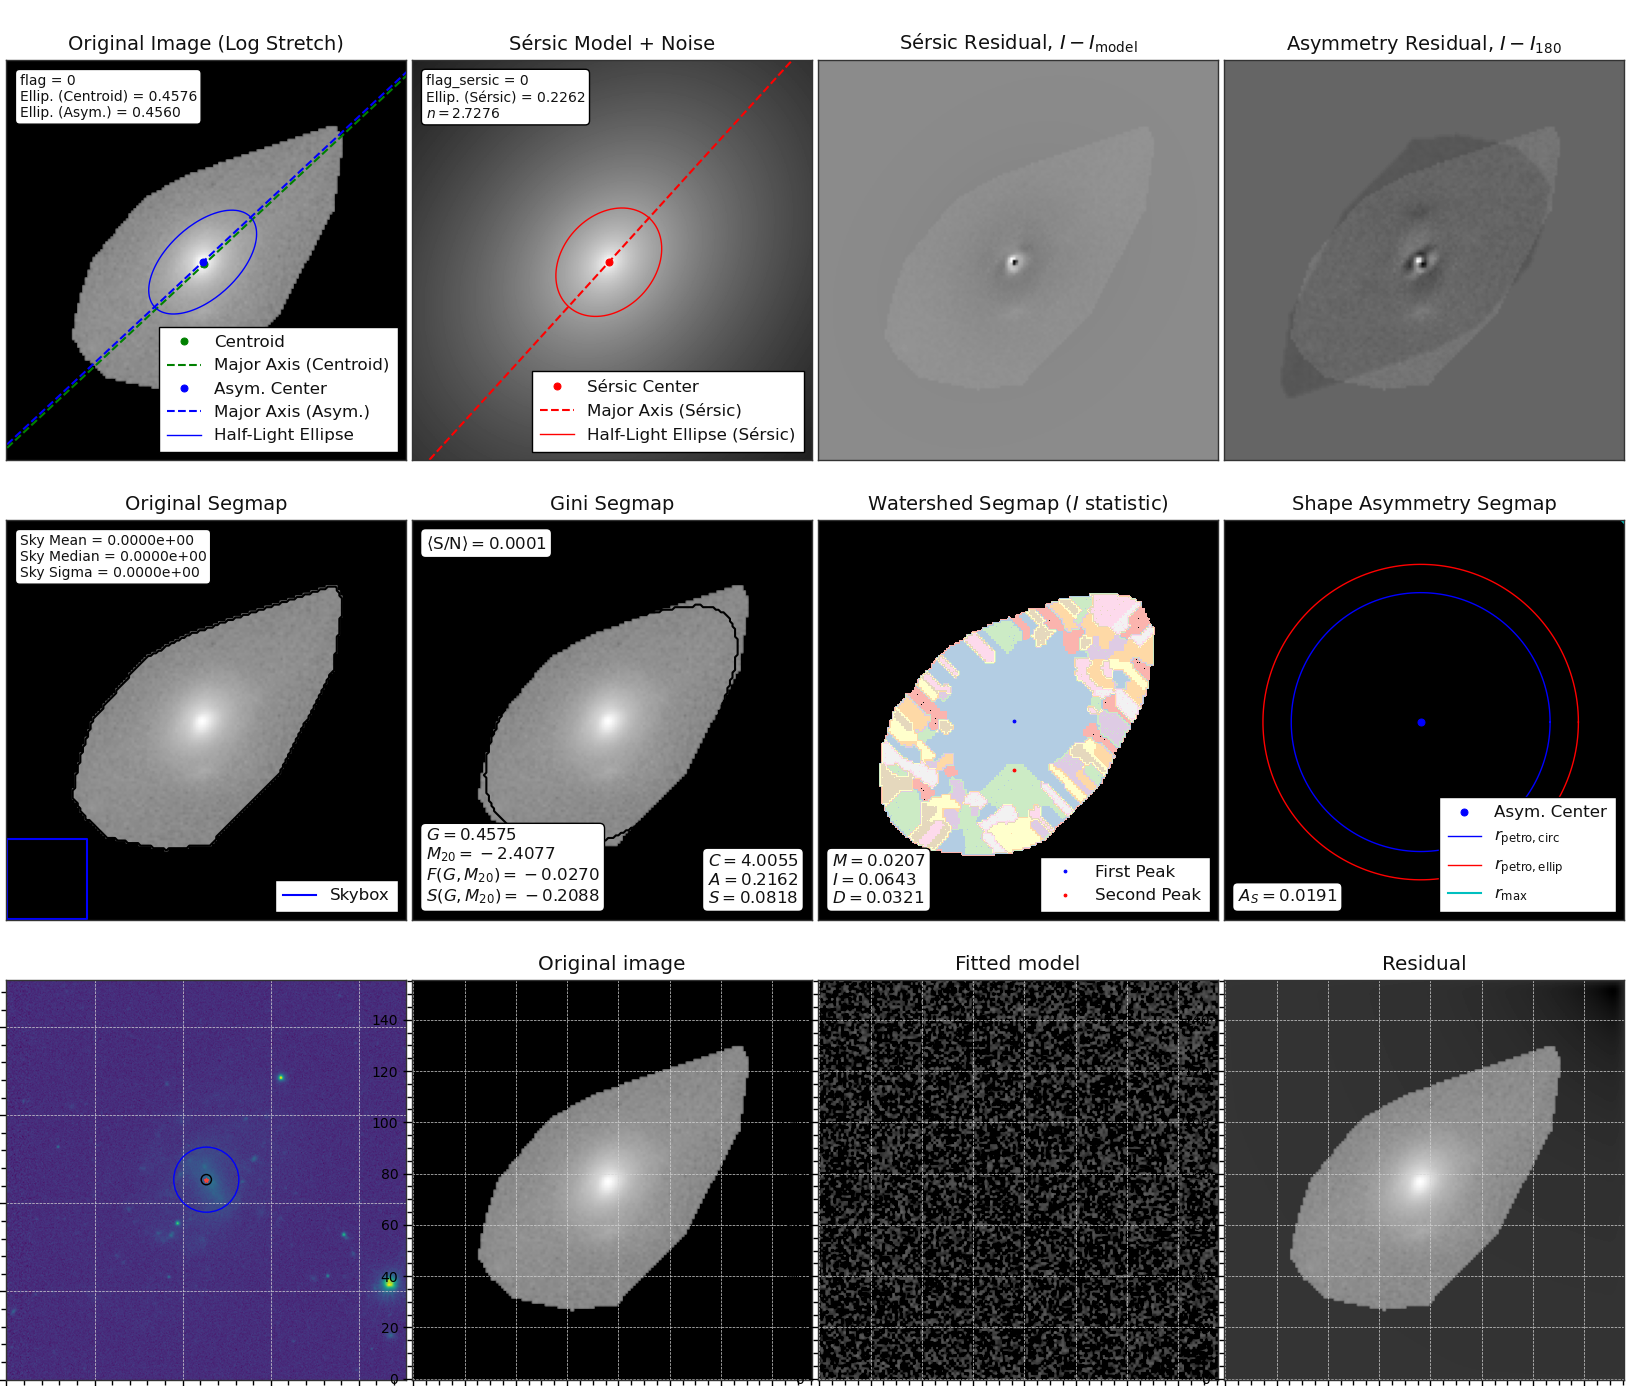

<IPython.core.display.Javascript object>


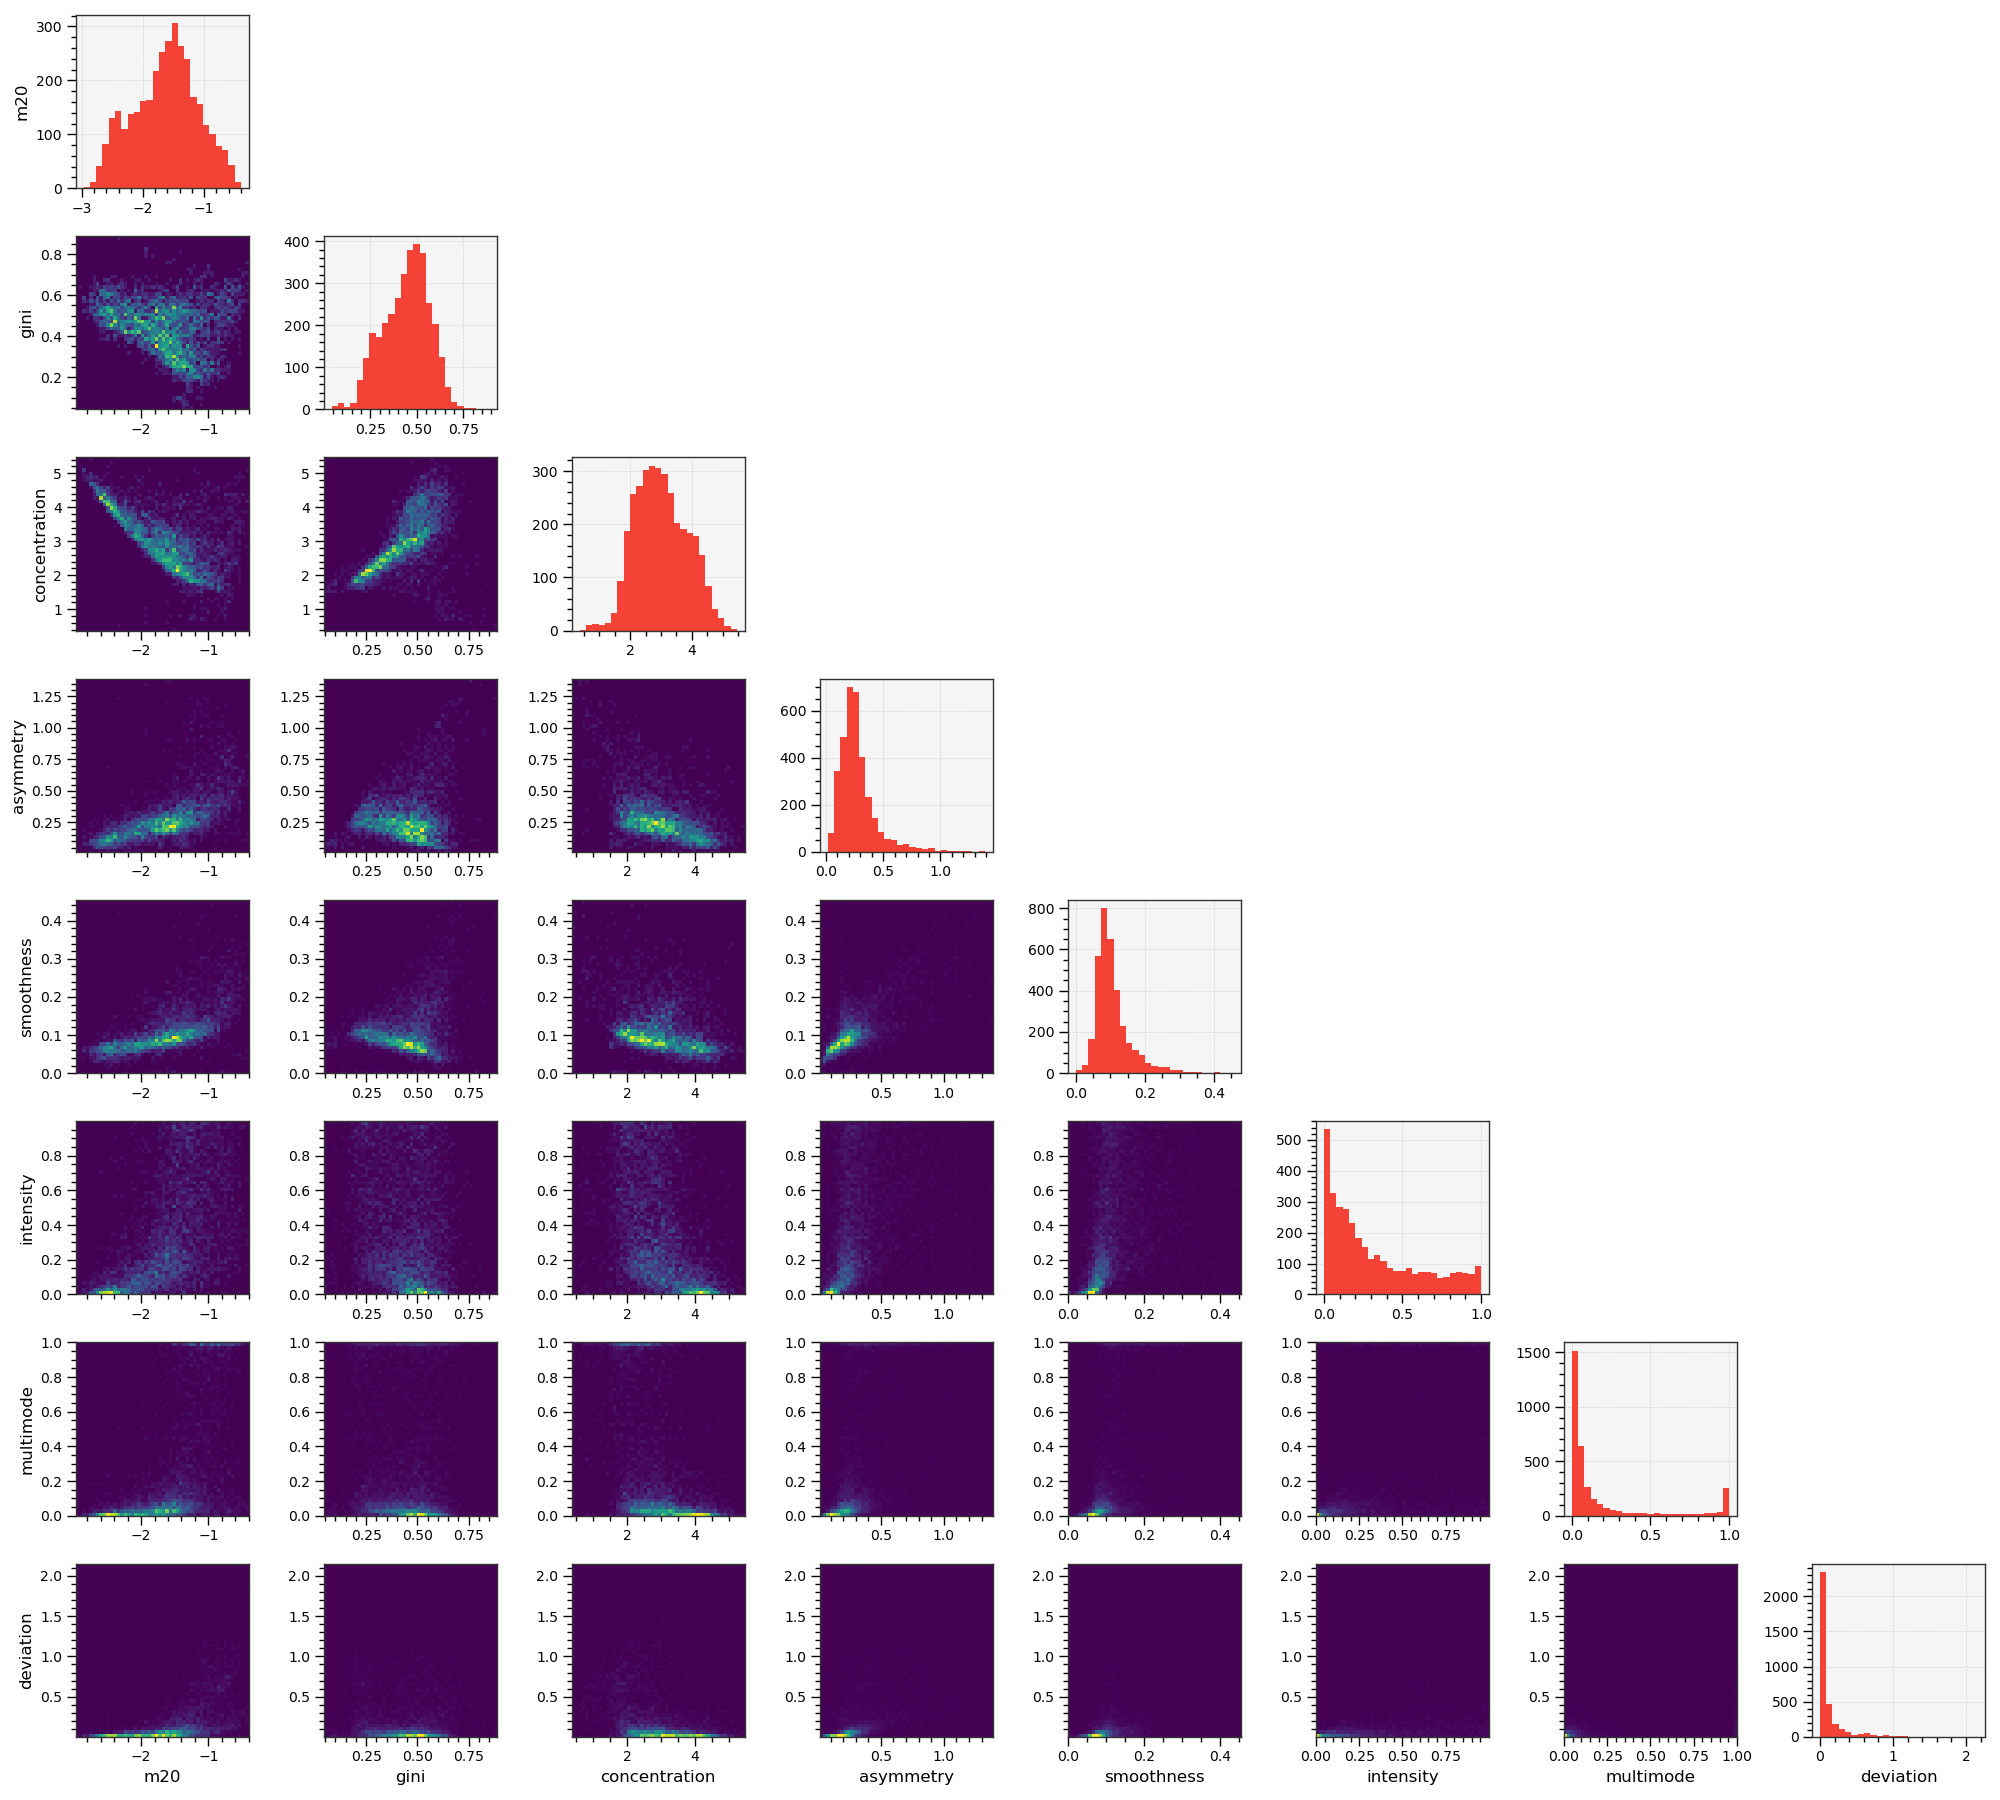

In [177]:
# Draw a Matrix plot
targets = ['m20', 'gini', 'concentration', 'asymmetry', 'smoothness', 'intensity', 'multimode', 'deviation']
n_targets = len(targets)
fig, axs = plt.subplots(n_targets,n_targets)
fig.set_size_inches(20,18)
for i, (rows, tg_r) in enumerate(zip(axs,targets)):
    for j, (ax, tg_c) in enumerate(zip(rows,targets)):
        if i < j:
            ax.axis('off') 
            continue
        if tg_r == tg_c:
            ax.hist(result_arr[tg_c], bins=25)
        else:
            ax.hist2d(result_arr[tg_c], result_arr[tg_r], bins=50)
        if j==0: 
            ax.set_ylabel(f'{tg_r}')
        if i==n_targets-1:
            ax.set_xlabel(f'{tg_c}')

plt.tight_layout()
plt.savefig(out_dir+"Morph_matrix.png", dpi=144, facecolor='white')
plt.show()

### Thoughts

'multimode' and 'deviation' seem less useful unless scaled otherwise. 

# StatMorph + EFIGI Catalog

In [178]:
fn_cat = '../../bf_data/EFIGI_catalog/catalog/efigi.dat'

catalog_fields=[('ID',int),('RA',float),('dec',float),('T',float),('T_lo',float),('T_up',float),
                ('Arm_S',float),('Arm_S_up',float),('Arm_S_lo',float),
                ('Arm_C',float),('Arm_C_up',float),('Arm_C_lo',float),
                ('Arm_R',float),('Arm_R_up',float),('Arm_R_lo',float),
                ('Bar_L',float),('Bar_L_up',float),('Bar_L_lo',float),
                ('Ring_Inner',float),('Ring_Inner_up',float),('Ring_Inner_lo',float),
                ('Ring_Outer',float),('Ring_Outer_up',float),('Ring_Outer_lo',float),
                ('Ring_Pseudo',float),('Ring_Pseudo_up',float),('Ring_Pseudo_lo',float),
                ('Perturb',float),('Perturb_up',float),('Perturb_lo',float),
                ('Dust_vis',float),('Dust_vis_up',float),('Dust_vis_lo',float),
                ('Dust_disp',float),('Dust_disp_up',float),('Dust_disp_lo',float),
                ('Floc',float),('Floc_up',float),('Floc_lo',float),
                ('Hot_spot',float),('Hot_spot_up',float),('Hot_spot_lo',float),
                ('Incl',float),('Incl_up',float),('Incl_lo',float),
                ('Contam',float),('Contam_up',float),('Contam_lo',float),
                ('Multp',float),('Multp_up',float),('Multp_lo',float)]
full_catalog = np.genfromtxt(fn_cat, dtype=catalog_fields)#, converters={0: lambda s: int(re.split('(\d+)',s)[1])})

# PCG_name are string. Let's keep IDs only.
IDs = np.genfromtxt(fn_cat, dtype='str', usecols=0)
convert = lambda s: int(re.split('(\d+)',s)[1])
full_catalog['ID'] = np.array(list(map(convert, IDs)))

fields_stripped = [('ID',int), ('T',float), ('Arm_S',float), ('Arm_C',float), ('Arm_R',float),
                ('Bar_L',float), ('Ring_Inner',float), ('Ring_Outer',float), ('Ring_Pseudo',float),
                ('Perturb',float), ('Dust_vis',float), ('Dust_disp',float), ('Floc',float),
                ('Hot_spot',float), ('Incl',float), ('Contam',float), ('Multp',float)]
catalog = np.zeros(len(full_catalog), 
                dtype=fields_stripped)

for name,dty in fields_stripped: catalog[name] = full_catalog[name]

In [179]:
# Load catalog
ind_good = catalog['ID'].searchsorted(result_arr['id'])
goodcat = catalog[ind_good]

### Gini - M20 w/ demarcation

<IPython.core.display.Javascript object>


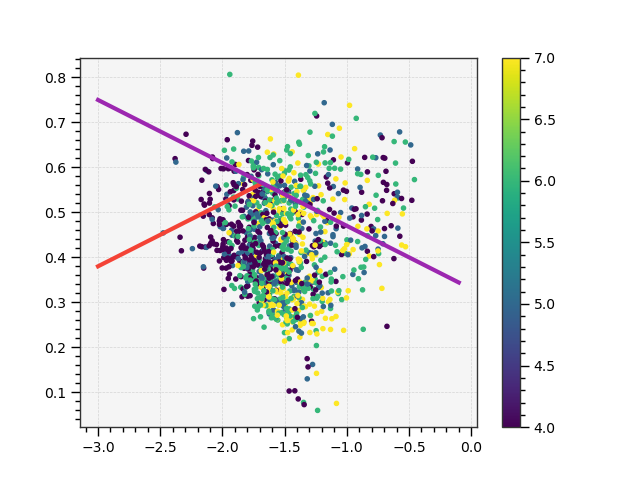

In [182]:
demarc1 = lambda x : 0.14*x + 0.8
demarc2 = lambda x : -0.14*x + 0.33

ind0 = np.where((goodcat['T'] >= -3) * (goodcat['T'] < 0))[0]
ind1 = np.where((goodcat['T'] >=  4) * (goodcat['T'] < 8))[0]
fig, ax = plt.subplots()

xx = np.array([-3, -1.7])
ax.plot(xx, demarc1(xx), lw=3)
xx = np.array([-3, -0.1])
ax.plot(xx, demarc2(xx), lw=3)
im=ax.scatter(result_arr['m20'][ind1],
              result_arr['gini'][ind1],
              c=goodcat['T'][ind1])
plt.colorbar(im)
plt.show()

### M20 vs concentration - inverse correlation expected

<IPython.core.display.Javascript object>


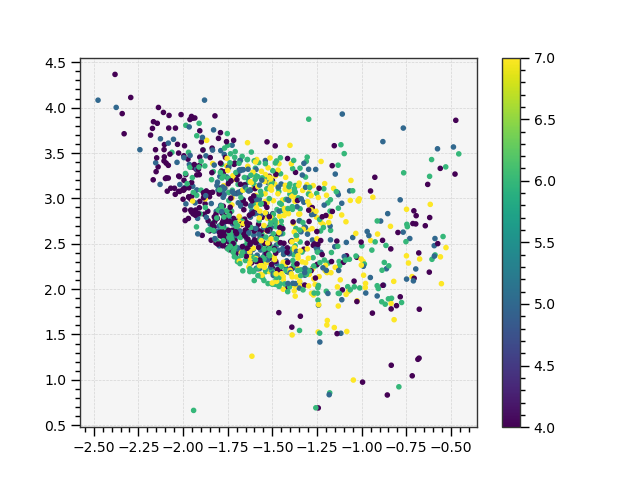

In [183]:
ind0 = np.where((goodcat['T'] >= -3) * (goodcat['T'] < 0))[0]
ind1 = np.where((goodcat['T'] >=  4) * (goodcat['T'] < 8))[0]
fig, ax = plt.subplots()

im=ax.scatter(result_arr['m20'][ind1],
              result_arr['concentration'][ind1],
              c=goodcat['T'][ind1])
plt.colorbar(im)
plt.show()

<IPython.core.display.Javascript object>


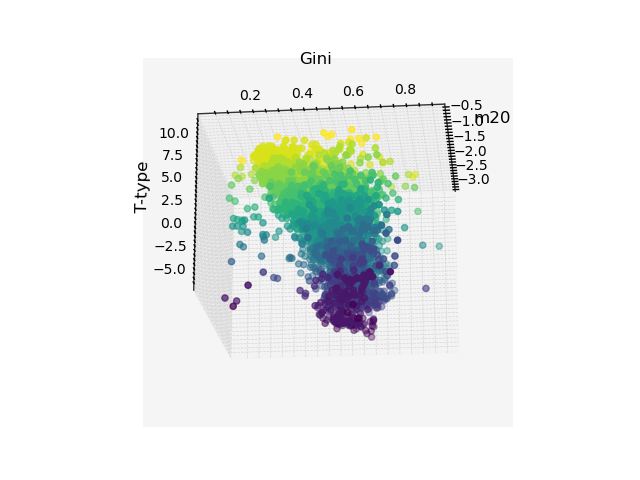

In [184]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result_arr['m20'],
           result_arr['gini'],
           goodcat['T'], c = goodcat['T'])

ax.set_xlabel('m20')
ax.set_ylabel('Gini')
ax.set_zlabel('T-type')

plt.show()

Hmmm, Can I really separate them??? 


### PCA

<IPython.core.display.Javascript object>


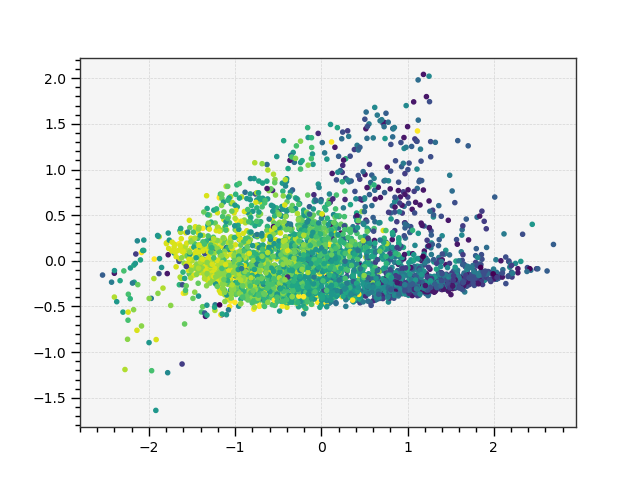

In [214]:
from sklearn import neighbors
from sklearn.decomposition import PCA

data = np.zeros((len(result_arr), 6))
for i, ff in enumerate(['m20', 'gini', 'concentration', 'asymmetry', 'smoothness', 'intensity']):
    data[:,i] = result_arr[ff]

pca = PCA(n_components = 4)

proj = pca.fit_transform(data)

plt.ion()
plt.scatter(proj[:, 0], proj[:, 1], c=goodcat['T'])
plt.show()

## simple linear regression with 6 quantities

In [264]:
from sklearn.linear_model import LinearRegression

In [282]:
data = np.zeros((len(result_arr), 6))
for i, ff in enumerate(['m20', 'gini', 'concentration', 'asymmetry', 'smoothness', 'intensity']):
    data[:,i] = result_arr[ff]
target = goodcat['T']

train = data[:3000,:]
test = data[3000:,:]
reg = LinearRegression().fit(train, target[:3000])

pred = reg.predict(test)

print(reg.coef_)

[ -0.1385608   -6.67930423  -2.36067145  -2.70995263  15.83301989
   3.08923966]


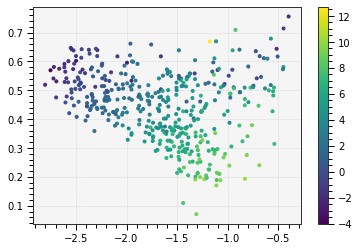

In [279]:
# Predicted Gini Vs M20
fig, ax = plt.subplots()

im=ax.scatter(test[:,0],
              test[:,1],
              c=pred)
plt.colorbar(im)
plt.show()

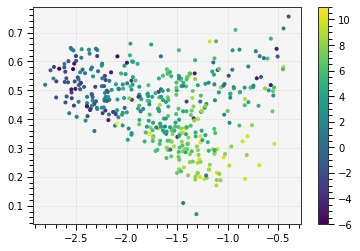

In [281]:
# Real values
fig, ax = plt.subplots()

im=ax.scatter(test[:,0],
              test[:,1],
              c=goodcat['T'][3000:])
plt.colorbar(im)
plt.show()

### SOM

In [215]:
from minisom import MiniSom

In [217]:
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

In [223]:
### Initialization and training ###
som = MiniSom(10,10,data.shape[1],sigma=1.0,learning_rate=0.5)
som.pca_weights_init(data)
print("Training...")
som.train_random(data,1000, verbose=True) # training with 100 iterations
print("\n...ready!")

Training...
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.740133686988

...ready!


In [235]:
len(np.unique(goodcat['T']))

18

In [255]:
from matplotlib import cm

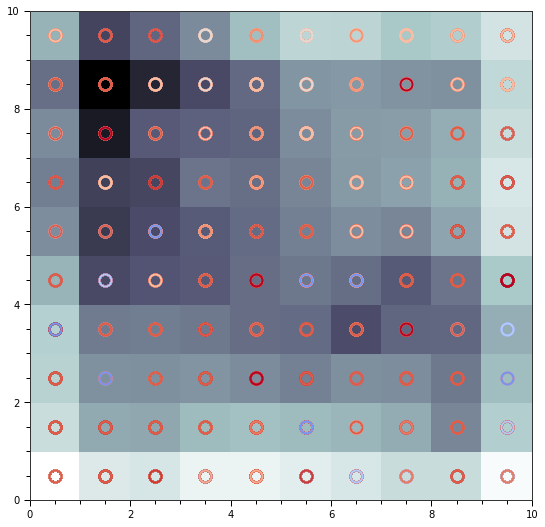

In [263]:
%matplotlib inline

plt.figure(figsize=(9, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background

target = goodcat['T'].astype(int)
colors = cm.coolwarm((target - target.min())/target.ptp())
target *= int(target.ptp())

for cnt, xx in enumerate(data):
    w = som.winner(xx)
    plt.plot(w[0]+.5, w[1]+.5, "o", markerfacecolor='None',
             markeredgecolor=colors[target[cnt]], markersize=12, markeredgewidth=2)

plt.show()

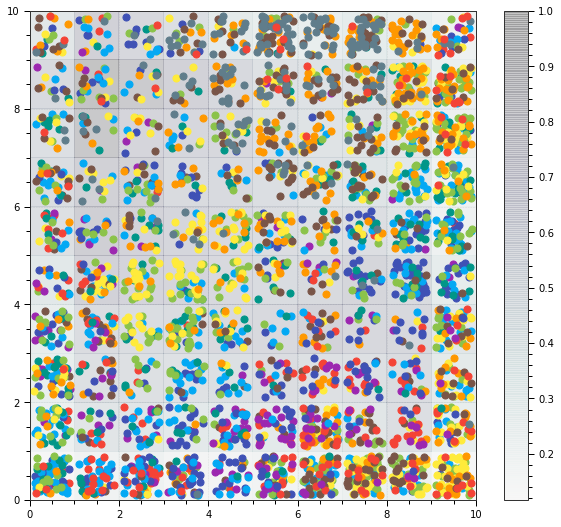

In [240]:
w_x, w_y = zip(*[som.winner(d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1])#, label=label_names[c])
#plt.legend(loc='upper right')
plt.grid()
#plt.savefig('resulting_images/som_seed.png')
plt.show()

## TabNet
https://github.com/dreamquark-ai/tabnet
https://arxiv.org/pdf/1908.07442.pdf


1. remove ID. This is non-physical value. 
2. remove RA and dec for the same reason. 
3. T-type is a type of categorical embedding. Is it satisfactory? 
4. ignore confidential intervals for now.

In [10]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

from pytorch_tabnet.pretraining import TabNetPretrainer

clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # This will be overwritten if using pretrain model
                      )

X_train = smorph_arr

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain
    
) 

## cf) XGBoost

## WND-CHARM

In [12]:
from skimage.data import chelsea
img = chelsea()

matrix = PyImageMatrix()
matrix.allocate(img.shape[1], img.shape[0])
numpy_matrix = matrix.as_ndarray()
numpy_matrix[:] = img[:,:,1]

In [13]:
fv = FeatureVector( name='FromNumpyMatrix', long=True, original_px_plane=matrix )
fv.GenerateFeatures(quiet=False, write_to_disk=True)

LOADED  <FeatureVector "FromNumpyMatrix" n_features=2919 fs_col=0>


<FeatureVector "FromNumpyMatrix" n_features=2919 fs_col=0>

Best TMO params for each type(T,size) of galaxy

In [ ]:
T-type -> 살짝 mapping?? 

gsize_p = 
gsize_area =
gsize_Ra = 

e.i., 
params_t1_size_1 = (a', b', mi', mo')
params_t1_size_2 = (a', b', mi', mo')-1
params_t2_size_1 = (a', b', mi', mo')-2 
,...
,...
,...
...
.
.
.

Pixel(?)/ Size -binned
-> size dependency

WND-CHARM 



How to choose good TMO parameter set? 
->  objective : Maximize distance between T-types.

(a,b,mid_i, mid_o) = F(T-type, galaxysize)   <- Bayesian optimization? 

**사람 눈에 잘 구분되는게 목표!**
Feature set도 사람 눈에 잘 보이는 feature들이 더 중요할 것. 

In [14]:
fv.values

array([  4.46700000e+03,   1.44827590e-02,   5.44697210e-03, ...,
        -1.95719420e+00,   1.95081660e+01,   7.23149870e-01])

In [115]:
# Load data for testing
import pickle

hdulist = fits.open(fns_r[174])
img = hdulist[0].data

mask = pickle.load(open("./PGC0000243_mask.pickle", 'rb'))

img[~mask] = 0
stamp = gen_stamp(img, pad=10, aspect_ratio="no", eps=eps)
#stamp += eps
stamp -= 1.01*stamp.min()

# 3. Tone map (widget)

In [117]:
from colour.plotting import (CONSTANTS_COLOUR_STYLE, artist, override_style)
from ipywidgets import GridspecLayout, Layout, Image, Button, IntSlider, FloatSlider, ToggleButtons, VBox, HBox, Box

def tonemapping_operator_generic(x,
                             a=0.125,
                             d=0.975,
                             mid_in=0.25,
                             mid_out=0.18):
    hdr_max = x.max()
    ad = a * d
    midi_pow_a  = pow(mid_in, a)
    midi_pow_ad = pow(mid_in, ad)
    hdrm_pow_a  = pow(hdr_max, a)
    hdrm_pow_ad = pow(hdr_max, ad)
    u = hdrm_pow_ad * mid_out - midi_pow_ad * mid_out
    v = midi_pow_ad * mid_out

    b = -((-midi_pow_a + (mid_out * (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v)) / u) / v)
    c = (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v) / u

    x[x>hdr_max] = hdr_max
    z = np.power(x, a)
    return z / (np.power(z, d) * b + c)


def plot_tmo_plt(x,
                 a=0.125,
                 d=0.975,
                 mid_in=0.25,
                 mid_out=0.18,
                 log_scale=False,
                 cctf_encoding=CONSTANTS_COLOUR_STYLE.colour.colourspace.cctf_encoding):
    
    args = (a,d,mid_in, mid_out)
    image = tonemapping_operator_generic(x, *args)
    luminance_function = np.squeeze(tonemapping_operator_generic(np.linspace(0, 1, 200)))

    shape = image.shape
    bounding_box = [0, 1, 0, 1]

    image = np.clip(cctf_encoding(image), 0, 1)

    plt.ioff()
    fig = plt.figure()
    fig.set_size_inches(4,4)
    #self.fig = fig
    axes = fig.add_subplot()

    im = axes.imshow(image,
                     aspect=shape[0] / shape[1],
                     extent=bounding_box,
                     interpolation='nearest')

    lf, = axes.plot(np.linspace(0, 1, len(luminance_function)),
                       luminance_function,
                       color='red')

    if log_scale:
        axes.set_xlabel('$log_2$ Input Luminance')
        axes.set_xscale('log', basex=2)
        axes.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(0.5))
        axes.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.ion()
    plt.show()

In [154]:
hdulist = fits.open(too_deem_fns[-1])
hdulist[0].data -= (hdulist[0].data.min() - eps) 
img = hdulist[0].data

In [155]:
# Initial values 
a=0.125
d=0.975
mid_in=0.25
mid_out=0.18
log_scale=False
cctf_encoding=CONSTANTS_COLOUR_STYLE.colour.colourspace.cctf_encoding

#x = stamp
x = img
lum_points = np.linspace(0, 1, 200)

args = (a,d,mid_in, mid_out)
image = tonemapping_operator_generic(x, *args)
luminance_function = np.squeeze(tonemapping_operator_generic(lum_points))

shape = image.shape
bounding_box = [0, 1, 0, 1]

image = np.clip(cctf_encoding(image), 0, 1)


#############################
plt.ioff()
fig = plt.figure()
fig.set_size_inches(4,4)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
axes = fig.add_subplot()

im = axes.imshow(image,
                 aspect=shape[0] / shape[1],
                 extent=bounding_box,
                 interpolation='nearest')

lf, = axes.plot(np.linspace(0, 1, len(luminance_function)),
                   luminance_function,
                   color='red')

if log_scale:
    axes.set_xlabel('$log_2$ Input Luminance')
    axes.set_xscale('log', basex=2)
    axes.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(0.5))
    axes.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ion()
#plt.show()


def update(change):
    if (change['new'] != change['old']):
        image = tonemapping_operator_generic(x,
                                             a=a.value,
                                             d=d.value,
                                             mid_in=mid_in.value,
                                             mid_out=mid_out.value)
        lum_fun = np.squeeze(tonemapping_operator_generic(lum_points,
                                                          a=a.value,
                                                          d=d.value,
                                                          mid_in=mid_in.value,
                                                          mid_out=mid_out.value))
        # Update tonemapped image
        im.set_data(image)
        lf.set_ydata(lum_fun)
        fig.canvas.draw_idle()

a=FloatSlider(min=0.1, max=1.5, step=0.01, continuous_update=False, description='a')
d=FloatSlider(min=0.5, max=3.0, step=0.01, continuous_update=False, description='d')
mid_in=FloatSlider(min=0.1, max=1, step=0.01, continuous_update=False, description='mid_in')
mid_out=FloatSlider(min=0.1, max=1, step=0.01, continuous_update=False, description='mid_out')

a.observe(update, names=['value']) # name of FloatSlider's trait to be observed
d.observe(update, names=['value'])
mid_in.observe(update, names=['value'])
mid_out.observe(update, names=['value'])

ui = VBox([a,d,mid_in,mid_out])

#mapped_image = Box(fig.canvas)
the_box = HBox([fig.canvas, ui])
the_box

In [156]:
plt.savefig("PGC0013406_1.49_1.66_0.95_0.29.png")

## TM curves applied to raw images

In [147]:
def get_values(control):
    return {ctr.description:ctr.value for ctr in control}

tmo_params = get_values(ui.children)

In [148]:
tmo_params

{'a': 1.49, 'd': 1.66, 'mid_in': 0.95, 'mid_out': 0.29}

In [4]:
too_deem = [2365, 8225, 9406, 10117, 13406]

In [102]:
gids = np.asarray(gids)
too_deem_fns=[fns_r[np.where(gids==target_gid)[0].squeeze()] for target_gid in too_deem]

In [161]:
import os

try:
    out_dir = basedir+"{}_{}_{}_{}/".format(*tmo_params.values())
    os.mkdir(out_dir)
except:
    pass

In [150]:
sub_rows = 3
fig, axs = plt.subplots(sub_rows, sub_rows)
fig.set_size_inches(12,12)
axs = axs.ravel()
for ax, fn in zip(axs, too_deem_fns):
    img_name = fn.split("/")[-2]
    hdulist = fits.open(fn)

    # Ensure pixel values are positive
    hdulist[0].data -= (hdulist[0].data.min() - eps) 
    hdulist[0].data = tonemapping_operator_generic(hdulist[0].data, **tmo_params)
    #hdulist[0].data[hdulist[0].data < 10*eps] = eps
    mask, img, mask_new = mask_utils.gmm_mask(hdulist,
                                   max_n_comp=20, 
                                   sig_factor=2.0, 
                                   verbose=False, 
                                   do_plot=False,
                                   npix_min=50)
    ax.imshow(np.log10(img))
    ax.imshow(mask, alpha=0.5)
    #mask_new = mask_hull(mask, ax)
    ax.text(0.05,0.05, img_name, transform=ax.transAxes)
    pickle.dump(mask_new, open(out_dir+f"{img_name}_mask.pickle", "wb"))
plt.tight_layout()
plt.savefig(out_dir+f"deem.png", dpi=144)
plt.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-150-e32abd56a28e>:19: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img))
<ipython-input-150-e32abd56a28e>:19: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img))
<ipython-input-150-e32abd56a28e>:19: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img))
<ipython-input-150-e32abd56a28e>:19: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img))
<ipython-input-150-e32abd56a28e>:19: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img))


In [20]:
import ipywidgets as widgets
from ipywidgets import FloatSlider
from IPython.display import display

from astrobf.utils import tmo_utils 

def tonemapping_operator_generic_interactive(image,
                                             a=0.125,
                                             d=0.975,
                                             mid_in=0.25,
                                             mid_out=0.18):
    args = (a,d,mid_in, mid_out)
    return tmo_utils.plot_tonemapping_operator_image(
        tmo_utils.tonemapping_operator_generic(image, *args),
        np.squeeze(tmo_utils.tonemapping_operator_generic(np.linspace(0, 1, 512), *args)),
        title='Generic Tonemapping Operator')
    

tmo_widget = widgets.interactive(
            tonemapping_operator_generic_interactive,
            image=widgets.fixed(stamp),
            a=FloatSlider(min=0.1, max=1.5, step=0.01, continuous_update=False),
            d=FloatSlider(min=0.5, max=3.0, step=0.01, continuous_update=False),
            mid_in=FloatSlider(min=0.1, max=1, step=0.01, continuous_update=False),
            mid_out=FloatSlider(min=0.1, max=1, step=0.01, continuous_update=False))

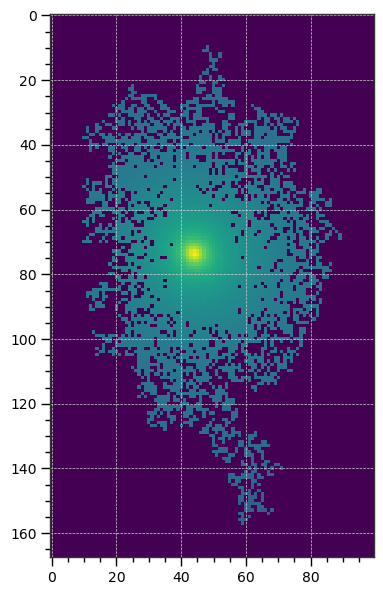

In [9]:
# Get the data out.
mapped = tmo_widget.result

plt.imshow(mapped)
plt.show()

In [ ]:
# get current tmo parameters

# 4. Feature extraction (WND-CHARM)

*Keypoint* extractors don't seem to be useful for morphological studies of galaxies.  

WND-CHARM is a generic image feature extractor. This is generic, since it calculates +2000 features of an image! 
Exact numbers of features for short/long ver. * gray/color images are given by 'diagnostics' function.

In [162]:
import wcharm
from wcharm import diagnostics

from skimage.io import imshow, imsave
from skimage.color import rgb2gray

print(diagnostics)

WND-CHARM Python API Diagnostics
Executable:
	/home/hoseung/anaconda3/envs/tm38/bin/python
PYTHONPATH environment variable:
	<unset>
WND-CHARM library path:
	/home/hoseung/Work/wnd-charm/build/lib.linux-x86_64-3.8/wcharm/wndcharm.py
WND-CHARM features major version: 4
	short: 4.1 (N = 1059)
	long: 4.2 (N = 2919)
	short_color: 4.3 (N = 2199)
	long_color: 4.4 (N = 4059)
Package versions:
	python    	3.8.0 (default, Nov  6 2019, 21:49:08)  [GCC 7.3.0]
	wndcharm  	None
	numpy     	1.19.2
	scipy     	1.5.2
	matplotlib	3.3.2
	sklearn   	0.23.2
	skimage   	0.17.2
	IPython   	7.19.0
	tifffile  	2020.12.8
	PIL       	8.1.0
	pandas    	1.1.4



WNDCHARM handles an image as a ImageMatrix. Following steps are to make an ImageMatrix object within Python. 

In [163]:
from wcharm.PyImageMatrix import PyImageMatrix

matrix = PyImageMatrix()
matrix.allocate(stamp.shape[1], stamp.shape[0])
numpy_matrix = matrix.as_ndarray()
numpy_matrix[:] = stamp

### Calculate feature vector

In [164]:
from wcharm.FeatureVector import FeatureVector

# Initialize a feature vector
fv = FeatureVector( name='FromNumpyMatrix', long=True, original_px_plane=matrix )
# fv == None for now.

fv.GenerateFeatures(quiet=False, write_to_disk=True)
print(fv.values)

CALCULATING FEATURES FROM None <FeatureVector "FromNumpyMatrix" fs_col=0>
CALCULATED: <FeatureVector "FromNumpyMatrix" n_features=2919 fs_col=0>
Writing signature file "FromNumpyMatrix-l.sig"
[  4.46700000e+03   1.44827586e-02   5.44697212e-03 ...,  -1.95719420e+00
   1.95081656e+01   7.23149867e-01]


But, why is the calculation SOOOOO fast???

Note that SIFT and SURF are **patented**, and they are missing from OpenCV install by default.  
You need additional component to be installed into opencv_contrib package. 

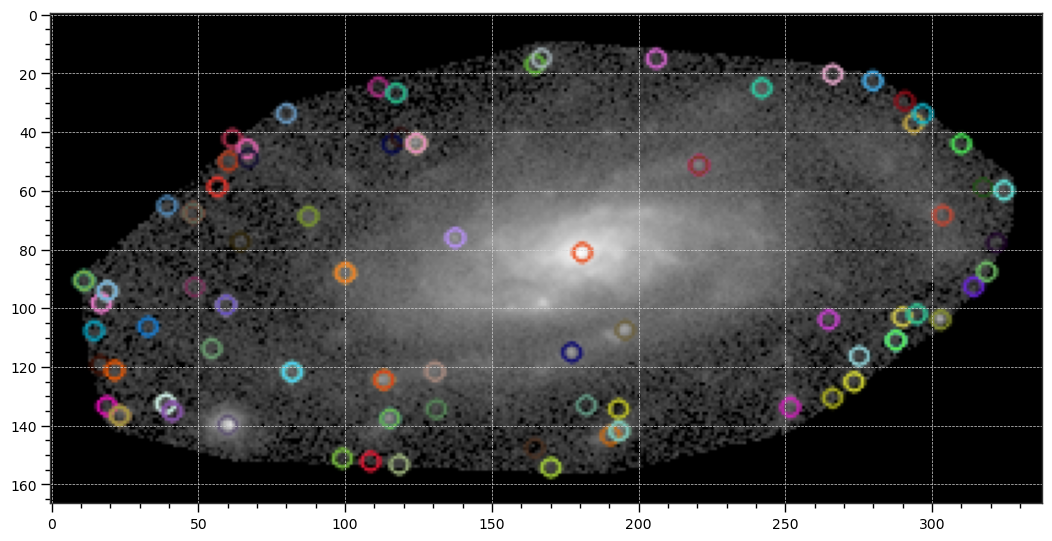

In [117]:
sift = cv.xfeatures2d.SIFT_create()
gray = (mapped*255).astype(np.uint8)
kp = sift.detect(gray,None)

shifted_img=cv.drawKeypoints(gray,kp,gray)

plt.imshow(shifted_img)
#cv.imwrite('sift_keypoints.jpg',shifted)

## What do they mean? How do I know I got reasonable feature set?

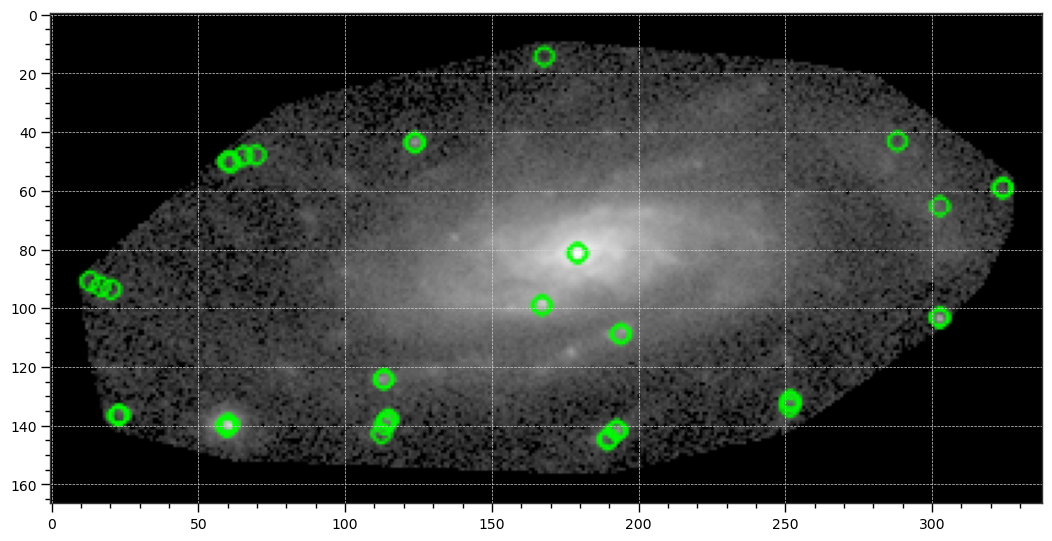

(<matplotlib.image.AxesImage at 0x7f51a7329b10>, None)

In [121]:
alg = cv.KAZE_create()
kp = alg.detect(gray)
kp, des = alg.compute(gray, kp)
img2 = cv.drawKeypoints(gray, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

# low-level feature 1. Color
## color correlogram

# low-level feature 2. texture
## Texture classification - Local Binary Pattern

## To do: ignore outside the galaxy mask 

In [126]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

METHOD = 'uniform'

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')

def do_lbp(image):
    lbp = local_binary_pattern(image, n_points, radius, METHOD)

    # plot histograms of LBP of textures
    fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    plt.gray()

    titles = ('edge', 'flat', 'corner')
    w = width = radius - 1
    edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
    flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
    i_14 = n_points // 4            # 1/4th of the histogram
    i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
    corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                     list(range(i_34 - w, i_34 + w + 1)))

    label_sets = (edge_labels, flat_labels, corner_labels)

    for ax, labels in zip(ax_img, label_sets):
        ax.imshow(overlay_labels(image, lbp, labels))

    for ax, labels, name in zip(ax_hist, label_sets, titles):
        counts, _, bars = hist(ax, lbp)
        highlight_bars(bars, labels)
        ax.set_ylim(top=np.max(counts[:-1]))
        ax.set_xlim(right=n_points + 2)
        ax.set_title(name)

    ax_hist[0].set_ylabel('Percentage')
    for ax in ax_img:
        ax.axis('off')


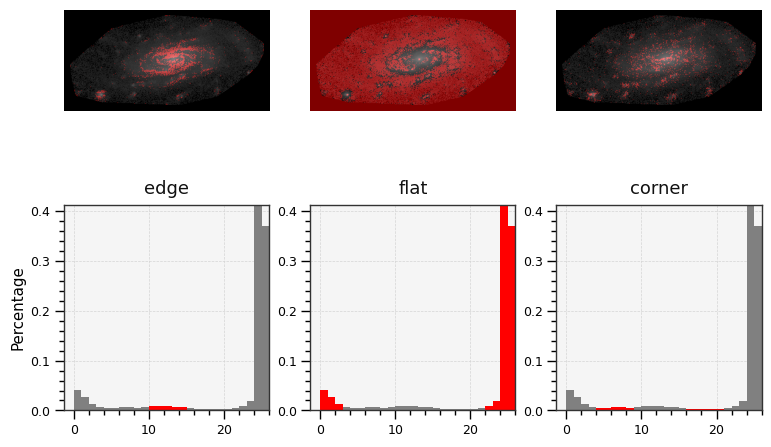

In [139]:
do_lbp(gray)

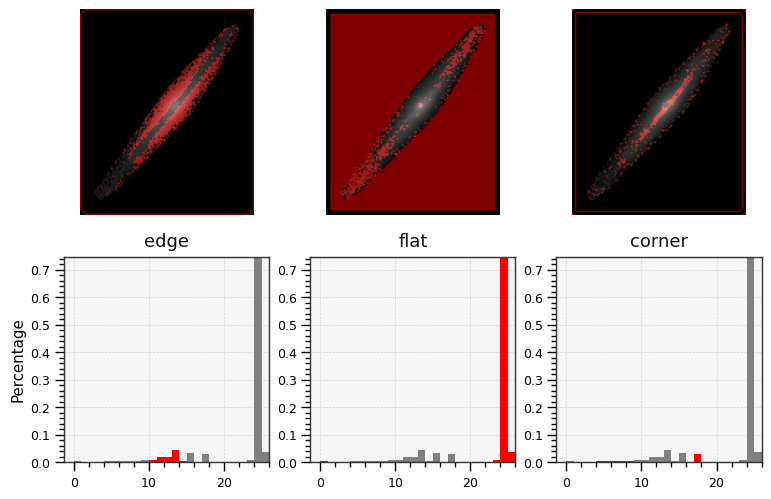

In [138]:
do_lbp(mapped)

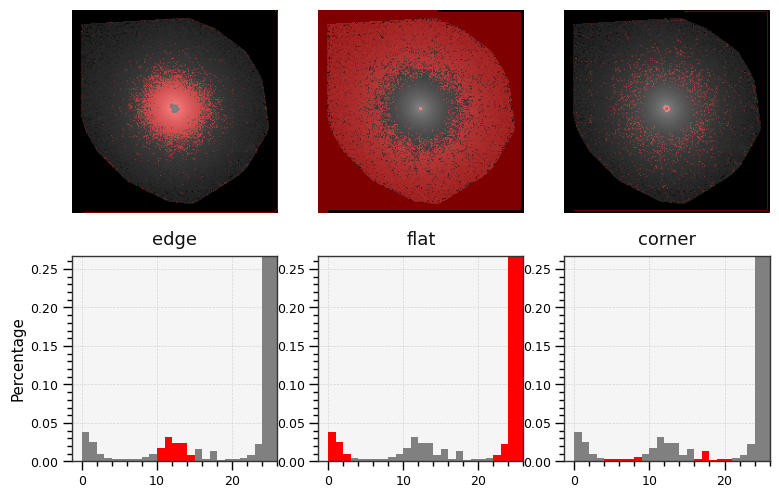

In [152]:
etg = tmo_widget.result
do_lbp(etg)

## Distance (divergence)

Rotated images matched against references using LBP:
original: spiral, rotated: 30deg, match result:  spiral
original: edgeon, rotated: 70deg, match result:  etg
original: etg, rotated: 145deg, match result:  etg


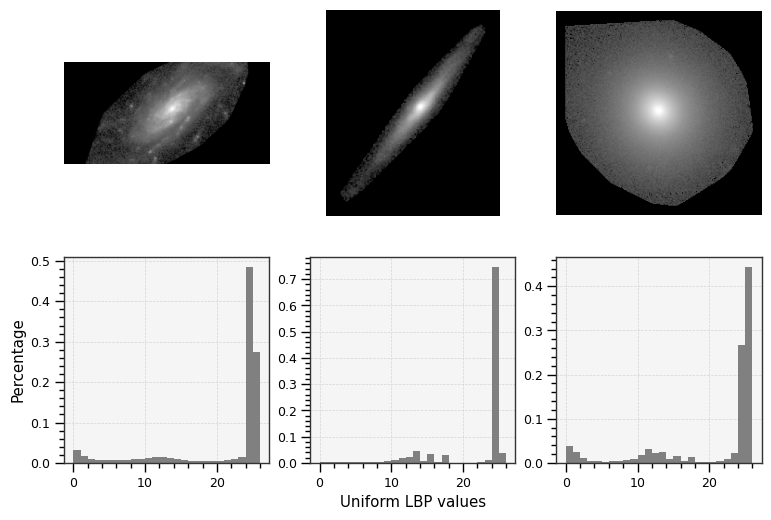

In [157]:
def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))


def match(refs, img):
    best_score = 10
    best_name = None
    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    for name, ref in refs.items():
        ref_hist, _ = np.histogram(ref, density=True, bins=n_bins,
                                   range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        if score < best_score:
            best_score = score
            best_name = name
    return best_name


spiral = gray
edgeon = mapped
refs = {
    'spiral': local_binary_pattern(spiral, n_points, radius, METHOD),
    'edgeon': local_binary_pattern(edgeon, n_points, radius, METHOD),
    'etg': local_binary_pattern(etg, n_points, radius, METHOD)
}

# classify rotated textures
print('Rotated images matched against references using LBP:')
print('original: spiral, rotated: 30deg, match result: ',
      match(refs, rotate(spiral, angle=30, resize=False)))
print('original: edgeon, rotated: 70deg, match result: ',
      match(refs, rotate(edgeon, angle=70, resize=False)))
print('original: etg, rotated: 145deg, match result: ',
      match(refs, rotate(etg, angle=145, resize=False)))

# plot histograms of LBP of textures
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,
                                                       figsize=(9, 6))
plt.gray()

ax1.imshow(rotate(spiral, angle=30, resize=False))
ax1.axis('off')
hist(ax4, local_binary_pattern(rotate(spiral, angle=30, resize=False), n_points, radius, METHOD))
ax4.set_ylabel('Percentage')

ax2.imshow(edgeon)
ax2.axis('off')
hist(ax5, refs['edgeon'])
ax5.set_xlabel('Uniform LBP values')

ax3.imshow(etg)
ax3.axis('off')
hist(ax6, refs['etg'])

plt.show()

## GLCM Texture Features
(DOI:10.1109/TSMC.1973.4309314)